In [1]:
# import modules

import numpy as np  
import pandas as pd  
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
filename = 'C:/data/properties_2017.csv'
prop = pd.read_csv(filename, nrows = 100000)

C:\Users\HMAHON\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


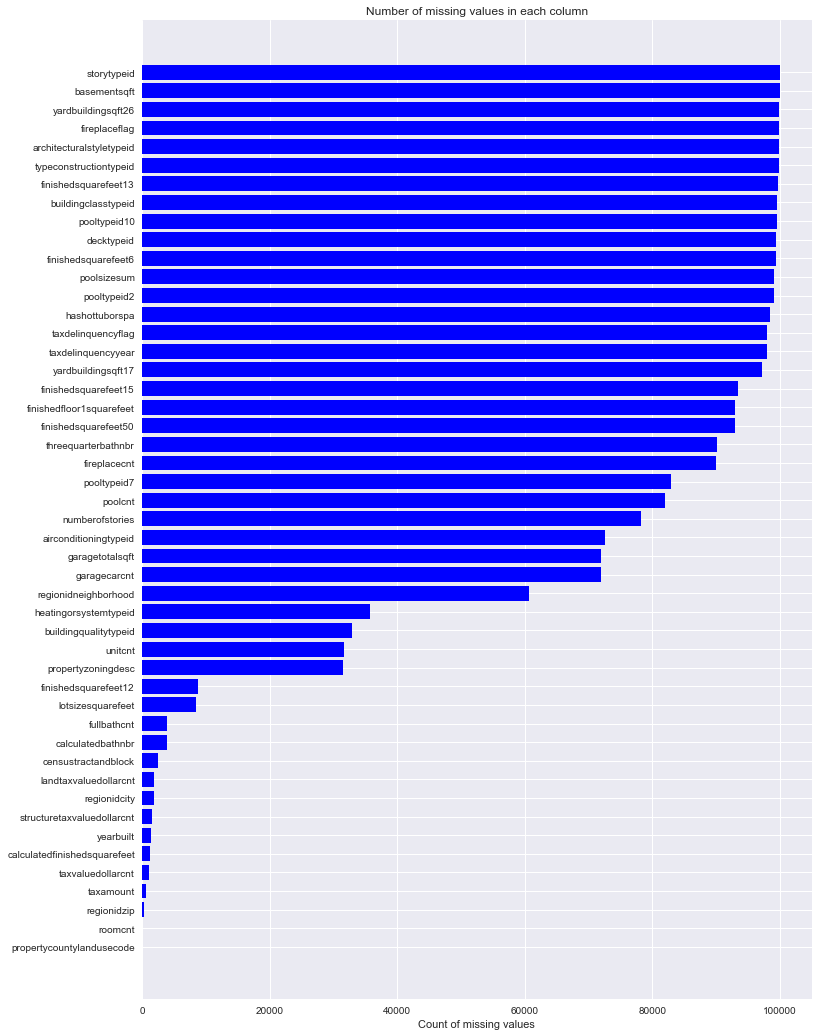

In [3]:
# Step 1

# Create a bar chart showing the null values per feature 


missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

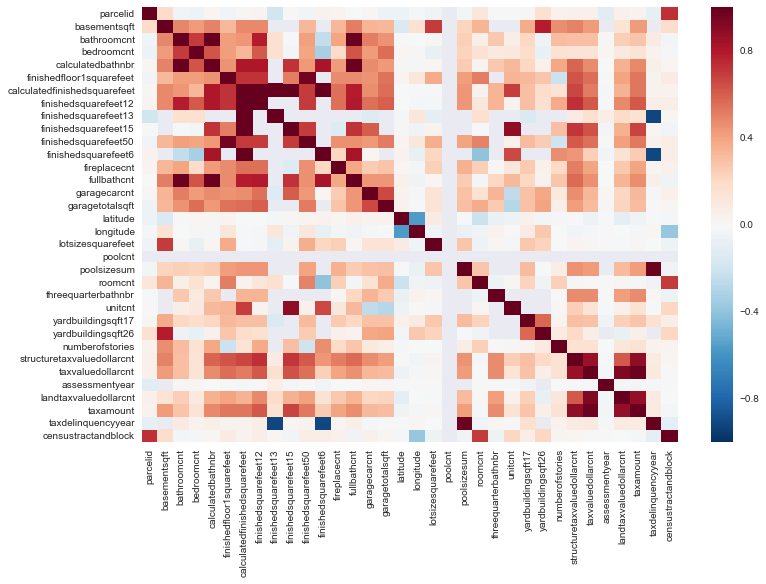

In [4]:
# Step 2

# Create a heat map to determine the correlation amongst the features 

# Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in prop.columns if x not in catcols]

# Create the heatmap
plt.figure(figsize = (12,8))
sns.heatmap(data=prop[numcols].corr())
plt.show()
plt.gcf().clear()

In [5]:
# Step 3

#Turn 'hashottuborspa' column into a 1/0 flag. 
# Need to replace True -> 1
# Assuming that N/A's mean that there's no hot tub/spa, so make that a 0

# replacing True with 1 from column's i'm identifying
prop['hashottuborspa'] = prop['hashottuborspa'].replace(True,1)

# replacing NaN (False) with 0 from column's i'm identifying
prop['hashottuborspa'] = prop['hashottuborspa'].fillna(0)

In [6]:
# Step 4

# Investigate 'pooltypeid10' and 'hashottuborspa'
# Assumption is these 2 fields should have the same info
# Instead, the data is inconsistent amongst the 2 fields

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field - these two fields should have the same information I assume?
print(prop.hashottuborspa.value_counts())
print(prop.pooltypeid10.value_counts())

#Remove 'pooltypeid10' as has more missing values
drop_list = ['pooltypeid10']
prop = prop.drop(drop_list, axis=1)

0.0    98495
1.0     1505
Name: hashottuborspa, dtype: int64
1.0    497
Name: pooltypeid10, dtype: int64


In [7]:
# Step 5

#Assume if the pooltype id column is null then pool/hottub doesnt exist 

index = prop.pooltypeid2.isnull()
prop.loc[index,'pooltypeid2'] = 0

index = prop.pooltypeid7.isnull()
prop.loc[index,'pooltypeid7'] = 0

index = prop.poolcnt.isnull()
prop.loc[index,'poolcnt'] = 0

In [8]:
# Step 6

# Compare the difference in the number of null values between 'poolcnt' and 'poolsizesum'

print 'poolsizesum initial null values = ', prop.poolsizesum.isnull().sum()
print(prop.poolcnt.value_counts())

# When 'poolcnt' = 1, fill 'poolsizesum' with median value. Assumption being that pools are roughly same size
poolsizesum_median = prop.loc[prop['poolcnt'] > 0, 'poolsizesum'].median()
prop.loc[(prop['poolcnt'] > 0) & (prop['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

# When 'poolcnt' = 0, make 'poolsizesum' also = 0
prop.loc[(prop['poolcnt'] == 0), 'poolsizesum'] = 0

# see results
print ''
print 'poolsizesum null values after transformation = ', prop.poolsizesum.isnull().sum()

poolsizesum initial null values =  99075
0.0    81907
1.0    18093
Name: poolcnt, dtype: int64

poolsizesum null values after transformation =  0


In [9]:
# Step 7

# Observe amount of null values in threequarterbathnbr and value counts
print 'initial threequarterbathnbr null values = ', prop.threequarterbathnbr.isnull().sum()
print prop.threequarterbathnbr.value_counts()


# Fill in missing data with most common value for threequarterbathnbr
# Do this b/c large majority of values have threequarterbathnbr = 1 

index = prop.threequarterbathnbr.isnull()
prop.loc[index,'threequarterbathnbr'] = 1

print ''
print 'after transformation threequarterbathnbr null values = ', prop.threequarterbathnbr.isnull().sum()
print prop.threequarterbathnbr.value_counts()

initial threequarterbathnbr null values =  90070
1.0    9840
2.0      81
4.0       4
3.0       4
5.0       1
Name: threequarterbathnbr, dtype: int64

after transformation threequarterbathnbr null values =  0
1.0    99910
2.0       81
4.0        4
3.0        4
5.0        1
Name: threequarterbathnbr, dtype: int64


In [10]:
# Step 8

# Observe amount of null values in airconditioningtypeid and value counts
print 'initial airconditioningtypeid null values = ', prop.airconditioningtypeid.isnull().sum()
print prop.airconditioningtypeid.value_counts()


# Fill in missing data with most common value for airconditioningtypeid
# Do this b/c large majority of values have airconditioningtypeid = 1, which is central ac

index = prop.airconditioningtypeid.isnull()
prop.loc[index,'airconditioningtypeid'] = 1

print ''
print 'after transformation airconditioningtypeid null values = ', prop.airconditioningtypeid.isnull().sum()
print prop.airconditioningtypeid.value_counts()

initial airconditioningtypeid null values =  72627
1.0     25142
13.0     1837
5.0       260
9.0        76
11.0       56
12.0        2
Name: airconditioningtypeid, dtype: int64

after transformation airconditioningtypeid null values =  0
1.0     97769
13.0     1837
5.0       260
9.0        76
11.0       56
12.0        2
Name: airconditioningtypeid, dtype: int64


In [11]:
# Step 9

# Observe amount of null values in heatingorsystemtypeid and value counts
print 'initial heatingorsystemtypeid null values = ', prop.heatingorsystemtypeid.isnull().sum()
print prop.heatingorsystemtypeid.value_counts()


# Fill in missing data with most common value for heatingorsystemtypeid
# Do this b/c most of values have heatingorsystemtypeid = 2, which is central heat

index = prop.heatingorsystemtypeid.isnull()
prop.loc[index,'heatingorsystemtypeid'] = 2

print ''
print 'after transformation heatingorsystemtypeid null values = ', prop.heatingorsystemtypeid.isnull().sum()
print prop.heatingorsystemtypeid.value_counts()

initial heatingorsystemtypeid null values =  35737
2.0     40062
7.0     22595
6.0       799
24.0      628
20.0      111
13.0       43
18.0       19
1.0         3
12.0        2
10.0        1
Name: heatingorsystemtypeid, dtype: int64

after transformation heatingorsystemtypeid null values =  0
2.0     75799
7.0     22595
6.0       799
24.0      628
20.0      111
13.0       43
18.0       19
1.0         3
12.0        2
10.0        1
Name: heatingorsystemtypeid, dtype: int64


In [12]:
# Step 10

# Compare the difference in the number of null values between 'garagecarcnt' and 'garagetotalsqft'

print 'initial garagecarcnt null values = ', prop.garagecarcnt.isnull().sum()
print 'initial garagetotalsqft null values = ', prop.garagetotalsqft.isnull().sum()

# Observe that they're the same amount of null values

#Assume if Null in garage count it means there are no garages
index = prop.garagecarcnt.isnull()
prop.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = prop.garagetotalsqft.isnull()
prop.loc[index,'garagetotalsqft'] = 0


initial garagecarcnt null values =  71992
initial garagetotalsqft null values =  71992


In [13]:
# Step 11

# Compare the difference in the number of null values between 'fireplacecnt' and 'fireplaceflag'

print 'initial fireplacecnt null values = ', prop.fireplacecnt.isnull().sum()
print 'initial fireplaceflag null values = ', prop.fireplaceflag.isnull().sum()

# Will create the fireplaceflag using fireplacecnt. 
# This is b/c fireplacecnt has less null values and b/c fireplaceflag should always be populated when fireplacecnt > 0
### Whenever a fireplacecnt is not null, then fireplaceflag = 1
### Whenever a fireplacecnt is null, then fireplaceflag = 0

prop['fireplaceflag']= 0
prop.loc[prop['fireplacecnt']>0,'fireplaceflag']= 1


### Whenever fireplacecnt is null, make fireplacecnt = 0

index = prop.fireplacecnt.isnull()
prop.loc[index,'fireplacecnt'] = 0

initial fireplacecnt null values =  89943
initial fireplaceflag null values =  99851


In [14]:
# Step 12

#Observe that 'calculatedfinishedsquarefeet' and 4 'finishedsquarefeet...' columns are very highly correlated.

# Remove the 4 'finishedsquarefeet' columns as they have the more missing values than 'calculatedfinishedsquarefeet'

print 'finishedsquarefeet12 null values = ', prop.finishedsquarefeet12.isnull().sum()
print 'finishedsquarefeet13 null values = ', prop.finishedsquarefeet13.isnull().sum()
print 'finishedsquarefeet15 null values = ', prop.finishedsquarefeet15.isnull().sum()
print 'finishedsquarefeet6 null values = ', prop.finishedsquarefeet6.isnull().sum()
print 'calculatedfinishedsquarefeet null values = ', prop.calculatedfinishedsquarefeet.isnull().sum()

drop_list = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']
prop = prop.drop(drop_list, axis=1)

finishedsquarefeet12 null values =  8846
finishedsquarefeet13 null values =  99715
finishedsquarefeet15 null values =  93444
finishedsquarefeet6 null values =  99325
calculatedfinishedsquarefeet null values =  1330


In [15]:
# Step 13

#'bathroomcnt', 'calculatedbathnbr', and 'fullbathcnt' also highly correlated. 
# again, seem to be the same information aswell according to the dictionary descriptions
# will choose 'bathroomcnt' as has no missing values, and the other two will be removed

print 'bathroomcnt null values = ', prop.bathroomcnt.isnull().sum()
print 'calculatedbathnbr null values = ', prop.calculatedbathnbr.isnull().sum()
print 'fullbathcnt null values = ', prop.fullbathcnt.isnull().sum()

drop_list = ['calculatedbathnbr', 'fullbathcnt']
prop = prop.drop(drop_list, axis=1)

bathroomcnt null values =  0
calculatedbathnbr null values =  3865
fullbathcnt null values =  3865


In [16]:
# Step 14

# Remove fields that are missing > 92% of data

missingvalues_prop = (prop.isnull().sum()/len(prop)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.92].field.tolist()
print(missingvalues_prop[missingvalues_prop['proportion']>.92])
prop = prop.drop(missingvaluescols, axis=1)

                       field  proportion
3               basementsqft     0.99947
34               storytypeid     0.99947
39        yardbuildingsqft26     0.99917
2   architecturalstyletypeid     0.99817
36    typeconstructiontypeid     0.99799
6        buildingclasstypeid     0.99554
8                 decktypeid     0.99400
49        taxdelinquencyyear     0.98024
48        taxdelinquencyflag     0.98024
38        yardbuildingsqft17     0.97181
11      finishedsquarefeet50     0.92987
9   finishedfloor1squarefeet     0.92987


In [17]:
# Step 15

# delete features witih object data type 

# find out which features are of object data type
prop.dtypes == object

drop_list = ['propertycountylandusecode','propertyzoningdesc' ]
prop = prop.drop(drop_list, axis=1)

In [18]:
# Step 16

#taxvaluedollarcnt set it equal to the tax amount (most correlated value) 

prop.loc[prop.taxvaluedollarcnt.isnull(),'taxvaluedollarcnt'] = prop.loc[prop.taxvaluedollarcnt.isnull(),'taxamount'] 


In [19]:
# Step 17

print 'Before fill with median'
print prop.isnull().sum().sort_values(ascending=False).head(10)


# Fill remaining null values with median

prop = prop.fillna(prop.median())

# check results
print ''
print 'After fill with median'
prop.isnull().sum().sort_values(ascending=False).head(5)

Before fill with median
numberofstories               78198
regionidneighborhood          60691
buildingqualitytypeid         32901
unitcnt                       31620
lotsizesquarefeet              8501
censustractandblock            2459
landtaxvaluedollarcnt          1910
regionidcity                   1909
structuretaxvaluedollarcnt     1511
yearbuilt                      1413
dtype: int64

After fill with median


censustractandblock    0
pooltypeid2            0
poolcnt                0
lotsizesquarefeet      0
longitude              0
dtype: int64

In [20]:
# Step 18

# Delete columns that are "cheating" based on my dependent variable being different than competition's
# These features are too closely correlated to target variable

drop_list = ['structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'assessmentyear']
prop = prop.drop(drop_list, axis=1)

In [21]:
# Step 19

# Take log of 'taxvaluedollarcnt'

log_fields = ['taxvaluedollarcnt']
for field in log_fields:
    prop[field] = np.log(prop[field])


# Model Comparision and Selection

In [22]:
# set up X and y
drop_list = ['taxvaluedollarcnt']
X = prop.drop(drop_list, axis=1)

y = prop.taxvaluedollarcnt

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=21)


In [23]:
# Random Forest Regressor baseline model

from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()

# fit the model to the data
regr.fit(X_train, y_train)

# test the model
y_pred = regr.predict(X_test)

# Score the model on training data
rf_score = regr.score(X_train, y_train)

In [24]:
# Linear Regression baseline model

from sklearn.linear_model import LinearRegression


regr = LinearRegression()

# fit the model to the data
regr.fit(X_train, y_train)

# test the model
y_pred = regr.predict(X_test)

# Score the model on training data
lr_score = regr.score(X_train, y_train)

In [25]:
# Lasso Regression baseline model

from sklearn.linear_model import Lasso

regr = Lasso(alpha=.15, normalize=True, fit_intercept=False)

# fit the model to the data
regr.fit(X_train, y_train)

# test the model
y_pred = regr.predict(X_test)

# Score the model on training data
lasso_score = regr.score(X_train, y_train)

C:\Users\HMAHON\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [26]:
# Ridge Regression baseline model

from sklearn.linear_model import Ridge

regr = Ridge()  

# fit the model to the data
regr.fit(X_train, y_train)

# test the model
y_pred = regr.predict(X_test)

# Score the model on training data
ridge_score = regr.score(X_train, y_train)

In [27]:
# Print all of the scores per each model

print 'Random Forest R2 score  = ', np.round(rf_score, 2)
print 'Linear Regression R2 score  = ', np.round(lr_score, 2)
print 'Lasso Regression R2 score  = ', np.round(lasso_score, 2)
print 'Ridge Regression R2 score  = ', np.round(ridge_score, 2)

Random Forest R2 score  =  0.93
Linear Regression R2 score  =  0.31
Lasso Regression R2 score  =  0.25
Ridge Regression R2 score  =  0.31


Clearly, Random Forest performed the best based on R2 of these 4 models. That will be the model type that will be used to build the final model below

# Random Forest Regressor

In [28]:
# set up X and y
drop_list = ['taxvaluedollarcnt', 'parcelid']
X = prop.drop(drop_list, axis=1)

y = prop.taxvaluedollarcnt

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=21)


In [29]:
# Set up RandomizedSearchCV to tune the hyperparameters

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 7)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 10, None] 
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True] #, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True], 'min_samples_leaf': [1, 2, 4, 8], 'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'min_samples_split': [2, 5, 10, 15], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 10, None]}


In [30]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=21, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'bootstrap': [True], 'min_samples_leaf': [1, 2, 4, 8], 'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'min_samples_split': [2, 5, 10, 15], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 10, None]},
          pre_dispatch='2*n_jobs', random_state=21, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [31]:
# Print out the best hyperparameters

rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 125}

In [32]:
# Create a function to evaluate the hyperparameter effect on the model

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [33]:
# Print the accuracy of the baseline model

base_model = RandomForestRegressor(n_estimators = 10, random_state = 21)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.5216 degrees.
Accuracy = 95.68%.


In [34]:
# Print the accuracy of the hypertuned model

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.4930 degrees.
Accuracy = 95.86%.


In [35]:
# Display the improvement the hyperparameter tuning had on the model

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.19%.


In [36]:
# Initialize the model using the hyperparameters from the Random Grid

regr = RandomForestRegressor(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=15,  n_estimators=125, random_state=21 )

# fit the model to the data
regr.fit(X_train, y_train)

# test the model
y_pred = regr.predict(X_test)

In [37]:
# Score the model on training data

print 'R2 = ', regr.score(X_train, y_train)     # want to be closer to 1

R2 =  0.811821095833


In [38]:
# Score the model on test data

print 'R2 = ', regr.score(X_test, y_test)    # want to be closer to 1

R2 =  0.663474669304


In [39]:
# Calculating Mean Squared Error of model

print 'MSE = ', sklearn.metrics.mean_squared_error(y_test, y_pred)    # values closer to 0 are better
# ^ MSE taking forever to run

MSE =  0.43319566034


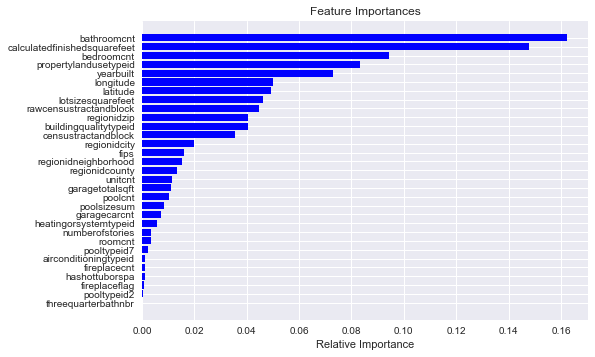

In [40]:
# Creating chart to show feature importance

x_col = X.columns
features=x_col
importances = regr.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()